# EECE5644, Homework 2
### Ethan Holand 6/4/22

In [45]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

from sys import float_info  # Threshold smallest positive floating value

import matplotlib.pyplot as plt # For general plotting

from math import ceil, floor 

import numpy as np
import pandas as pd

from scipy.stats import multivariate_normal
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Utility Functions

In [46]:
def generate_data_from_gmm(N, pdf_params, L=None, fig_ax=None):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['m'].shape[1]
    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)

    # Decide randomly which samples will come from each component
    u = np.random.rand(N)
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    if L.all() == None: # Default, no classes specified
        L = np.array(range(1, len(pdf_params['priors'])+1))

    for distribution in np.array(range(0, L.size)):
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[distribution] <= u) & (u <= thresholds[distribution+1]))[:, 0]
        # No. of samples in this component
        Nl = len(indices)  
        labels[indices] = L[distribution]
        X[indices, :] =  multivariate_normal.rvs(pdf_params['m'][distribution], pdf_params['C'][distribution], Nl)
    
    return X, labels

# def get_class_conditional_likelihoods(X, mu, sigma, L):
    
#     likelihoods = np.zeros((np.size(np.unique(L)), np.shape(X)[0]))
#     print(np.shape(likelihoods))

#     for distribution in np.array(range(0, L.size)):
#         print('start test')
#         print(likelihoods[:, L[distribution]])
#         print(np.array([multivariate_normal.pdf(X, mu[distribution], sigma[distribution])]))
#         likelihoods = likelihoods[:, L[distribution]] + np.array([multivariate_normal.pdf(X, mu[distribution], sigma[distribution])])

#     return likelihoods


## Evaluation Functions

In [47]:
# Generate ROC curve samples
def estimate_roc(discriminant_score, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Sorting necessary so the resulting FPR and TPR axes plot threshold probabilities in order as a line
    sorted_score = sorted(discriminant_score)

    # Use gamma values that will account for every possible classification split
    gammas = ([sorted_score[0] - float_info.epsilon] +
              sorted_score +
              [sorted_score[-1] + float_info.epsilon])

    # Calculate the decision label for each observation for each gamma
    decisions = [discriminant_score >= g for g in gammas]
    
    # Retrieve indices where FPs occur
    ind10 = [np.argwhere((d == 1) & (labels == 0)) for d in decisions]
    # Compute FP rates (FPR) as a fraction of total samples in the negative class
    p10 = [len(inds) / N_labels[0] for inds in ind10]
    # Retrieve indices where TPs occur
    ind11 = [np.argwhere((d == 1) & (labels == 1)) for d in decisions]
    # Compute TP rates (TPR) as a fraction of total samples in the positive class
    p11 = [len(inds) / N_labels[1] for inds in ind11]
    
    # ROC has FPR on the x-axis and TPR on the y-axis, but return others as well for convenience
    roc = {}
    roc['p10'] = np.array(p10)
    roc['p11'] = np.array(p11)

    return roc, gammas


def get_binary_classification_metrics(predictions, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Get indices and probability estimates of the four decision scenarios:
    # (true negative, false positive, false negative, true positive)
    class_metrics = {}
    
    # True Negative Probability Rate
    ind_00 = np.argwhere((predictions == 0) & (labels == 0))
    class_metrics['tnr'] = len(ind_00) / N_labels[0]
    # False Positive Probability Rate
    ind_10 = np.argwhere((predictions == 1) & (labels == 0))
    class_metrics['fpr'] = len(ind_10) / N_labels[0]
    # False Negative Probability Rate
    ind_01 = np.argwhere((predictions == 0) & (labels == 1))
    class_metrics['fnr'] = len(ind_01) / N_labels[1]
    # True Positive Probability Rate
    ind_11 = np.argwhere((predictions == 1) & (labels == 1))
    class_metrics['tpr'] = len(ind_11) / N_labels[1]

    return class_metrics

## Solution

In [48]:
# Generate dataset from three different distributions/categories
gmm_pdf = {}

# Class priors, splitting the first class into two halves
gmm_pdf['priors'] = np.array([0.325, 0.325, 0.35])
# True priors
gmm_pdf['true priors'] = np.array([0.65, 0.35])

# Mean and covariance of data pdfs conditioned on labels
gmm_pdf['m'] = np.array([[3, 0],
                         [0, 3],
                         [2, 2]])  # Gaussian distributions means
gmm_pdf['C'] = np.array([[[2, 0],
                          [0, 1]],
                         [[1, 0],
                          [0, 2]],
                         [[1, 0],
                          [0, 1]]])  # Gaussian distributions covariance matrices

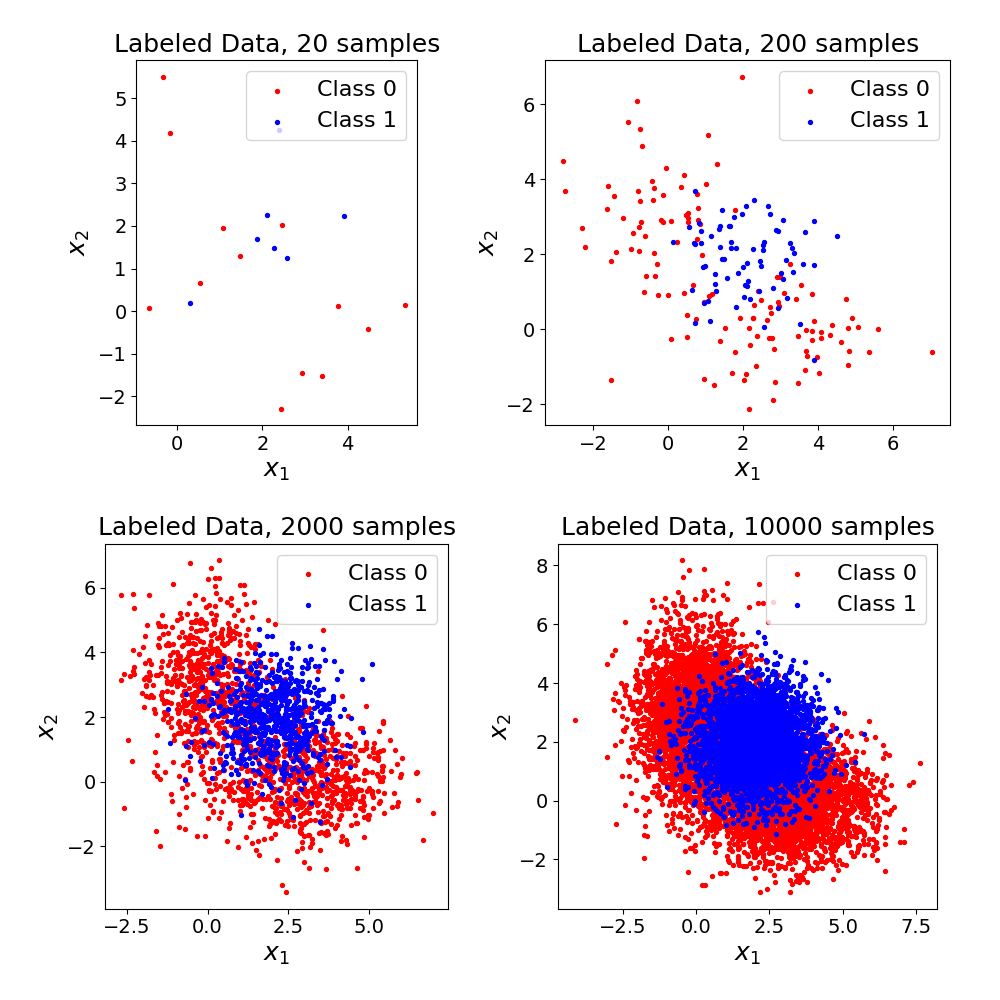

In [49]:
# Initialize dictionary and figure
datasets = {}
fig = plt.figure(figsize=(10, 10))

L = np.array([0, 0, 1]) # A list of the labels for each class distribution
N_sets = np.array([20, 200, 2000, 10000]) # Size of each dataset to be genreated

# Generate the data for each specified set size:
for i in np.array(range(0, N_sets.size)):
    N = N_sets[i] # Get number of samples
    
    X, labels = generate_data_from_gmm(N, gmm_pdf, L) # Generate data based on size, distribution, and labels

    # Plot the original data and their true labels

    ax_raw = fig.add_subplot(2, 2, i+1)
    ax_raw.scatter(X[labels == 0, 0], X[labels == 0, 1], c='r', s=8, label="Class 0")
    ax_raw.scatter(X[labels == 1, 0], X[labels == 1, 1], c='b', s=8, label="Class 1")
    ax_raw.set_xlabel(r"$x_1$")
    ax_raw.set_ylabel(r"$x_2$")
    ax_raw.set_aspect('equal', 'box') # Set equal axes for 3D plots

    plt.title("Labeled Data, {} samples".format(N))
    plt.legend()
    plt.tight_layout()

    # Store into dictionary:
    datasets['D'+str(N)] = {'N': N, 'X': X, 'labels': labels}

## Part 1: Determine theoretically optimal classifier
The theoretically optimal classifier for the dataset will be MAP, because we have true knowledge of the pdf.

[[0.09738323 0.10755351 0.00094536 ... 0.09098675 0.04159724 0.04403529]
 [0.02756778 0.02368502 0.00000157 ... 0.05037199 0.12757207 0.12633463]]


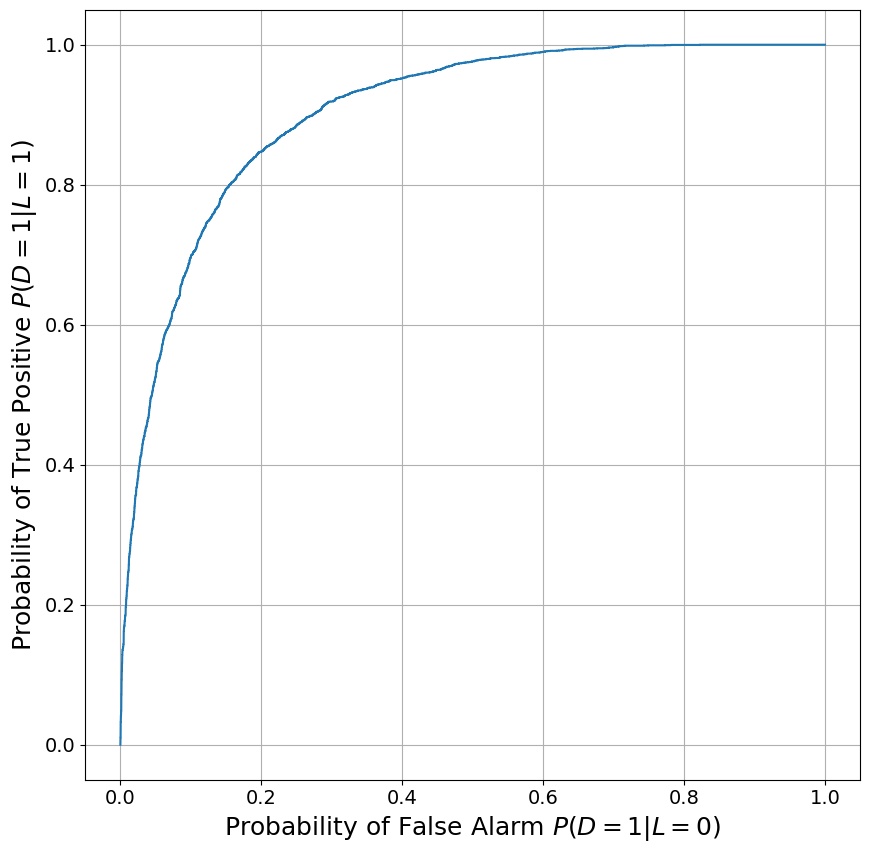

In [50]:
valid_set = 'D10000'

# Compute class conditional likelihoods to express ratio test, where ratio is discriminant score


class_conditional_likelihoods_0 = np.array([multivariate_normal.pdf(datasets[valid_set]['X'], gmm_pdf['m'][0], gmm_pdf['C'][0])]) + np.array([multivariate_normal.pdf(datasets[valid_set]['X'], gmm_pdf['m'][1], gmm_pdf['C'][1])])
class_conditional_likelihoods_1 = np.array([multivariate_normal.pdf(datasets[valid_set]['X'], gmm_pdf['m'][2], gmm_pdf['C'][2])])

class_conditional_likelihoods = np.append(class_conditional_likelihoods_0, class_conditional_likelihoods_1, axis =0)

print(class_conditional_likelihoods)

# print(get_class_conditional_likelihoods(datasets[valid_set]['X'], gmm_pdf['m'], gmm_pdf['C'], L))

# Class conditional log likelihoods equate to decision boundary log gamma in the 0-1 loss case
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Construct the ROC for ERM by changing log(gamma)
roc_erm, gammas_empirical = estimate_roc(discriminant_score_erm, labels)
# roc_erm returns a np.array of shape(2, N+2) where N+2 are the number of thresholds
# and 2 rows are the FPR and TPR respectively

plt.ioff() # Interactive plotting off
fig_roc, ax_roc = plt.subplots(figsize=(10, 10));
plt.ion()

ax_roc.plot(roc_erm['p10'], roc_erm['p11'], label="Empirical ERM Classifier ROC Curve")
ax_roc.set_xlabel(r"Probability of False Alarm $P(D=1|L=0)$")
ax_roc.set_ylabel(r"Probability of True Positive $P(D=1|L=1)$")

plt.grid(True)
display(fig_roc)
fig_roc;

Min Empirical P(error) for ERM = 0.169
Min Empirical Gamma = 0.955
Min Theoretical P(error) for ERM = 0.186
Min Theoretical Gamma = 1.857


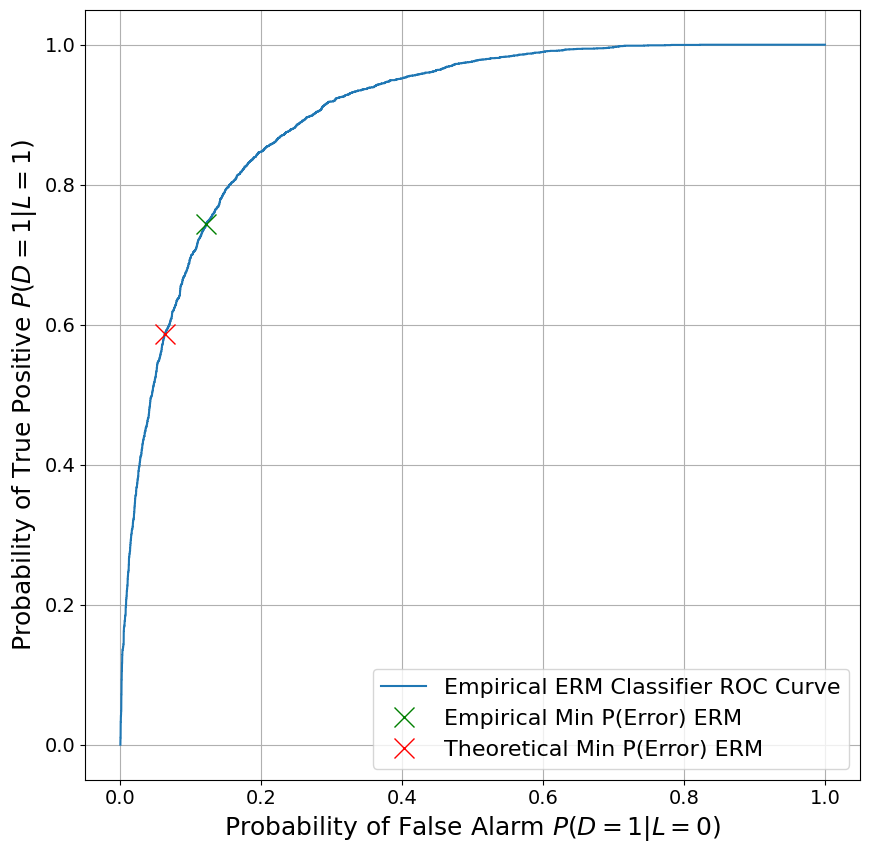

In [51]:
N_per_l = np.array([sum(labels == l) for l in [0,1]])

# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
# P(error; γ) = P(D = 1|L = 0; γ)P(L = 0)+P(D = 0|L = 1; γ)P(L = 1)
prob_error_empirical = np.array((roc_erm['p10'], 1 - roc_erm['p11'])).T.dot(N_per_l / datasets[valid_set]['N'])

# Min prob error for the empirically-selected gamma thresholds
min_prob_error_empirical = np.min(prob_error_empirical)
min_ind_empirical = np.argmin(prob_error_empirical)

# Compute theoretical gamma as log-ratio of true priors (0-1 loss) -> MAP classification rule
gamma_map = gmm_pdf['true priors'][0]/gmm_pdf['true priors'][1]
decisions_map = discriminant_score_erm >= np.log(gamma_map)

class_metrics_map = get_binary_classification_metrics(decisions_map, labels)
# To compute probability of error, we need FPR and FNR
min_prob_error_map = np.array((class_metrics_map['fpr'] * gmm_pdf['true priors'][0] + 
                               class_metrics_map['fnr'] * gmm_pdf['true priors'][1]))

# Plot theoretical and empirical
ax_roc.plot(roc_erm['p10'][min_ind_empirical], roc_erm['p11'][min_ind_empirical], 'gx', label="Empirical Min P(Error) ERM",
            markersize=14)
ax_roc.plot(class_metrics_map['fpr'], class_metrics_map['tpr'], 'rx', label="Theoretical Min P(Error) ERM", markersize=14)
plt.legend()

print("Min Empirical P(error) for ERM = {:.3f}".format(min_prob_error_empirical))
print("Min Empirical Gamma = {:.3f}".format(np.exp(gammas_empirical[min_ind_empirical])))

print("Min Theoretical P(error) for ERM = {:.3f}".format(min_prob_error_map))
print("Min Theoretical Gamma = {:.3f}".format(gamma_map))

display(fig_roc)

Smallest P(error) for ERM = 0.187


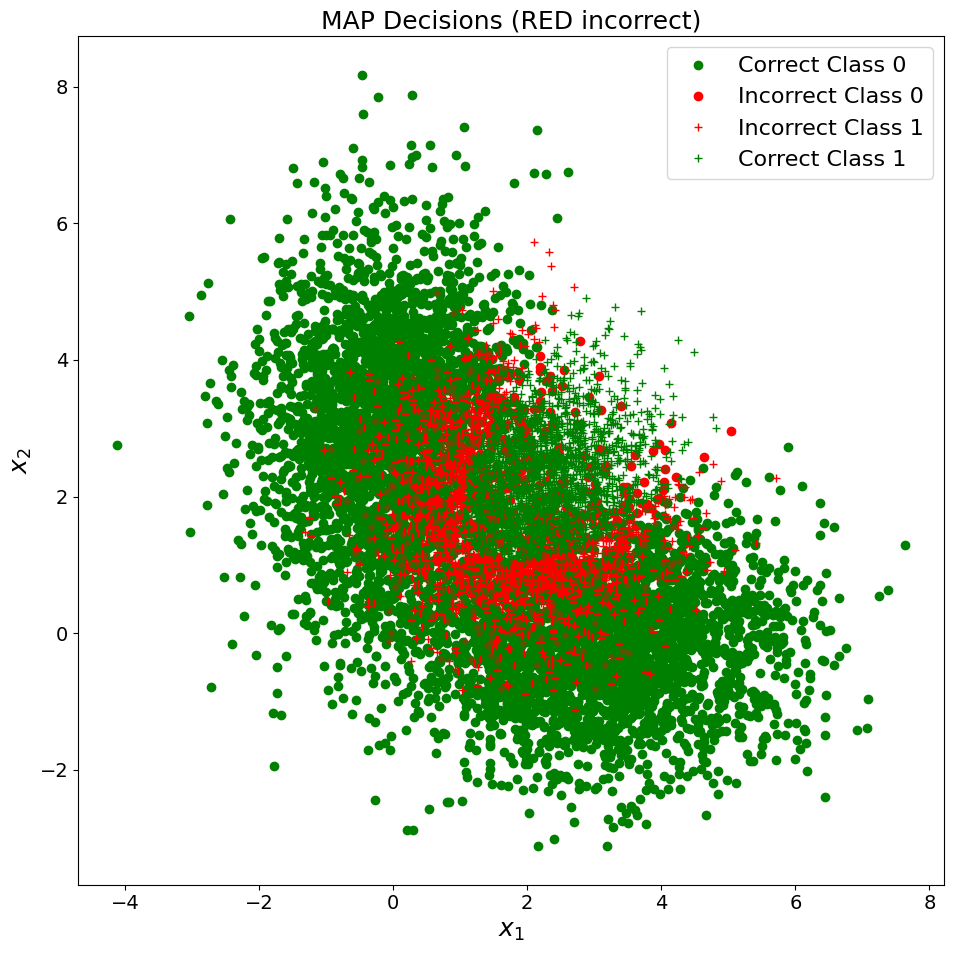

In [52]:
# Get indices and probability estimates of the four decision scenarios:
# (true negative, false positive, false negative, true positive)

# True Negative Probability
ind_00_map = np.argwhere((decisions_map==0) & (labels==0))
p_00_map = len(ind_00_map) / N_per_l[0]
# False Positive Probability
ind_10_map = np.argwhere((decisions_map==1) & (labels==0))
p_10_map = len(ind_10_map) / N_per_l[0]
# False Negative Probability
ind_01_map = np.argwhere((decisions_map==0) & (labels==1))
p_01_map = len(ind_01_map) / N_per_l[1]
# True Positive Probability
ind_11_map = np.argwhere((decisions_map==1) & (labels==1))
p_11_map = len(ind_11_map) / N_per_l[1]

# Probability of error for MAP classifier, empirically estimated
prob_error_erm = np.array((p_10_map, p_01_map)).dot(N_per_l.T / datasets[valid_set]['N'])
print("Smallest P(error) for ERM = {}".format(prob_error_erm))

# Display MAP decisions
plt.ioff() # These are Jupyter only lines to avoid showing the figure when I don't want
fig_disc_grid, ax_disc = plt.subplots(figsize=(10, 10));
plt.ion() # Re-activate "interactive" mode

# class 0 circle, class 1 +, correct green, incorrect red
ax_disc.plot(datasets[valid_set]['X'][ind_00_map, 0], datasets[valid_set]['X'][ind_00_map, 1], 'og', label="Correct Class 0");
ax_disc.plot(datasets[valid_set]['X'][ind_10_map, 0], datasets[valid_set]['X'][ind_10_map, 1], 'or', label="Incorrect Class 0");
ax_disc.plot(datasets[valid_set]['X'][ind_01_map, 0], datasets[valid_set]['X'][ind_01_map, 1], '+r', label="Incorrect Class 1");
ax_disc.plot(datasets[valid_set]['X'][ind_11_map, 0], datasets[valid_set]['X'][ind_11_map, 1], '+g', label="Correct Class 1");

ax_disc.legend();
ax_disc.set_xlabel(r"$x_1$");
ax_disc.set_ylabel(r"$x_2$");
ax_disc.set_title("MAP Decisions (RED incorrect)");
fig_disc_grid.tight_layout();

display(fig_disc_grid) # Display as .png

fig_disc_grid;

(2, 10000)


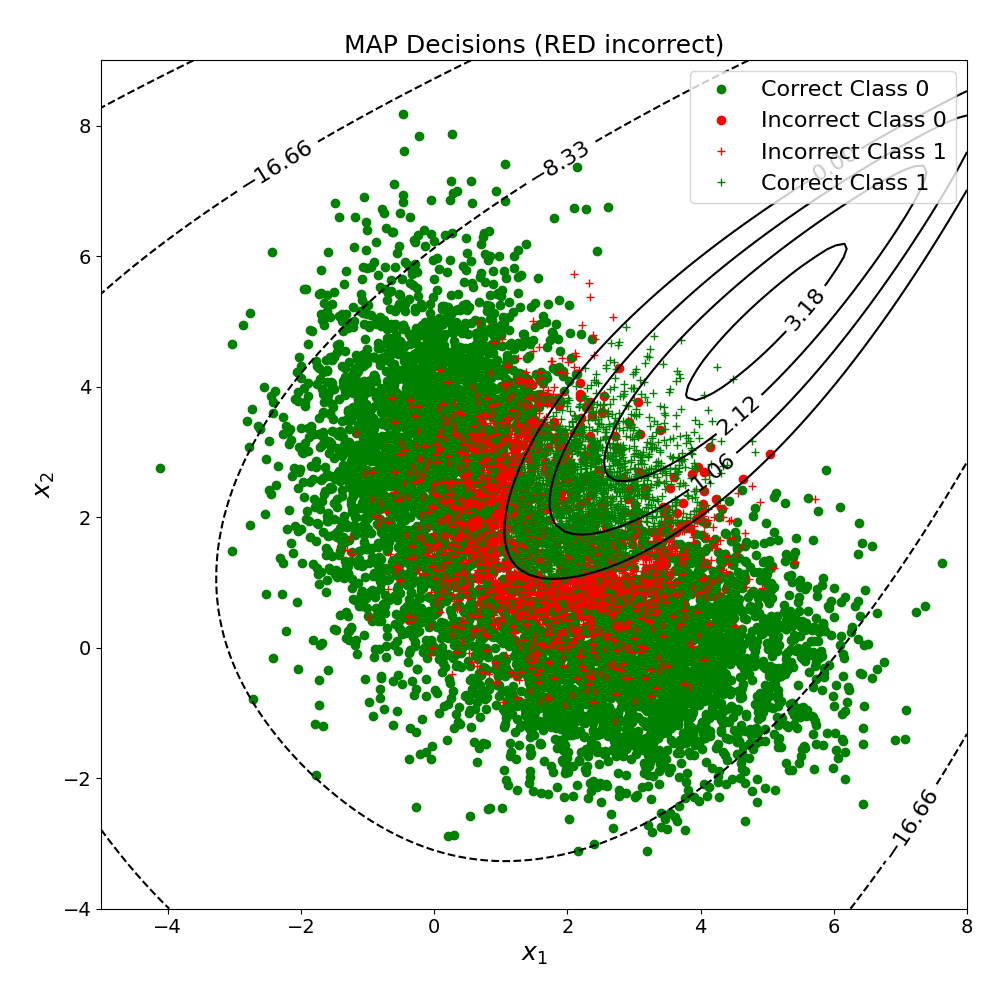

In [53]:
horizontal_grid = np.linspace(np.floor(np.min(datasets[valid_set]['X'][:,0])), np.ceil(np.max(datasets[valid_set]['X'][:,0])), 100)
vertical_grid = np.linspace(np.floor(np.min(datasets[valid_set]['X'][:,1])), np.ceil(np.max(datasets[valid_set]['X'][:,1])), 100)

# Generate a grid of scores that spans the full range of data 
[h, v] = np.meshgrid(horizontal_grid, vertical_grid)
# Flattening to feed vectorized matrix in pdf evaluation
gridxy = np.array([h.reshape(-1), v.reshape(-1)])
likelihood_grid_vals = np.array([multivariate_normal.pdf(gridxy.T, gmm_pdf['m'][0], gmm_pdf['C'][0]) + multivariate_normal.pdf(gridxy.T, gmm_pdf['m'][1], gmm_pdf['C'][1]), multivariate_normal.pdf(gridxy.T, gmm_pdf['m'][2], gmm_pdf['C'][2])])
# Where a score of 0 indicates decision boundary level
print(likelihood_grid_vals.shape)
discriminant_score_grid_vals = np.log(likelihood_grid_vals[1]) - np.log(likelihood_grid_vals[0]) - np.log(gamma_map)

# Contour plot of decision boundaries
discriminant_score_grid_vals = np.array(discriminant_score_grid_vals).reshape(100, 100)
equal_levels = np.array((0.3, 0.6, 0.9))
min_DSGV = np.min(discriminant_score_grid_vals) * equal_levels[::-1]
max_DSGV = np.max(discriminant_score_grid_vals) * equal_levels
contour_levels = min_DSGV.tolist() + [0] + max_DSGV.tolist()
cs = ax_disc.contour(horizontal_grid, vertical_grid, discriminant_score_grid_vals.tolist(), contour_levels, colors='k')
ax_disc.clabel(cs, fontsize=16, inline=1)

plt.show()
fig_disc_grid;

# My bad code

In [54]:
NLL = np.min(-np.sum(np.log(class_conditional_likelihoods), axis=0))

In [55]:
def bce(y, predictions):
    # Epsilon adjustment handles numerical errors by avoid underflow or overflow
    predictions = np.clip(predictions, float_info.epsilon, 1 - float_info.epsilon)
    # log P(Y=0 | x; theta)
    log_p0 = (1 - y) * np.log(1 - predictions + float_info.epsilon)
    # log P(Y=1 | x; theta)
    log_p1 = y * np.log(predictions + float_info.epsilon)

    return -np.mean(log_p0 + log_p1, axis=0)

In [56]:
# NLL loss, 1/N sum [y*log(g(X*theta)) + (1-y)*log(1-g(X*theta))]
print(bce(labels, decisions_map))

print(log_loss(labels, decisions_map))

6.610544661000199
6.458783729463707
